# 먼저 감정 분류를 먼저 학습하고 그 다음 공감 점수 회귀를 학습하기

In [1]:
import os
import numpy as np
from dataclasses import dataclass

import torch
import torch.nn as nn

from datasets import load_from_disk
from transformers import (
    AutoModel,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    set_seed,
)
from scipy.stats import spearmanr

# 1. Dataset 로드

In [2]:
DATASET_PATH = "./empathy_dataset/hf_tokenized_roberta-base"

ds = load_from_disk(DATASET_PATH)

# torch 텐서 포맷 맞춰주기
for split in ds.keys():
    ds[split].set_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels", "emotion_labels"],
    )

emotion_labels_tensor = ds["train"]["emotion_labels"][:]

# 추출한 텐서에 torch.max() 적용
num_emotions = int(torch.max(emotion_labels_tensor).item() + 1)
print("num_emotions:", num_emotions)

num_emotions: 32


# 1. Stage 1 - Emotion 전용 모델 학습
## 1-1 모델 정의: EmotionOnlyModel

In [3]:
MODEL_NAME = "roberta-base"  # 토크나이즈할 때 쓴 거랑 맞추기

class EmotionOnlyModel(nn.Module):
    def __init__(self, model_name: str, num_emotions: int):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size

        self.dropout = nn.Dropout(0.1)
        self.emo_head = nn.Linear(hidden_size, num_emotions)
        self.loss_ce = nn.CrossEntropyLoss()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        emotion_labels=None,   # Trainer가 label_names로 넘겨줄 것
        **kwargs,
    ):
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        cls = outputs.last_hidden_state[:, 0]  # [B, H]
        x = self.dropout(cls)

        emo_logits = self.emo_head(x)          # [B, C]

        loss = None
        if emotion_labels is not None:
            loss = self.loss_ce(emo_logits, emotion_labels)

        return {
            "loss": loss,
            "logits": emo_logits,
        }

## 1-2. Stage1용 metrics 함수 (emotion accuracy)

In [4]:
def compute_metrics_emotion(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    acc = float((preds == labels).mean())
    return {"accuracy": acc}

## 1-3. Stage1 TrainingArguments + Trainer

In [5]:
set_seed(43)

stage1_output_dir = "./empathy_roberta_stage1_emotion"

emotion_model = EmotionOnlyModel(MODEL_NAME, num_emotions)

training_args_stage1 = TrainingArguments(
    output_dir=stage1_output_dir,
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=15,              # 먼저 3 epoch 정도 시도
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    logging_steps=100,
    gradient_accumulation_steps=2,
    fp16=torch.cuda.is_available(),
    warmup_ratio=0.06,
    report_to="none",
    label_names=["emotion_labels"],  # 중요: emotion_labels만 loss에 사용
)

trainer_stage1 = Trainer(
    model=emotion_model,
    args=training_args_stage1,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics_emotion,
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 1-4. Stage1 학습 + encoder weight 저장

In [6]:
train_result_stage1 = trainer_stage1.train()
print("== Stage1 Train result ==")
print(train_result_stage1)

print("== Stage1 Best checkpoint ==", trainer_stage1.state.best_model_checkpoint)

# best encoder weight를 별도로 저장
encoder_state_path = "./emotion_encoder_stage1.pt"
torch.save(trainer_stage1.model.encoder.state_dict(), encoder_state_path)
print("Saved encoder state dict to:", encoder_state_path)

# validation / test 결과도 한 번 확인
metrics_val_stage1 = trainer_stage1.evaluate(ds["validation"])
print("== Stage1 Validation metrics ==")
print(metrics_val_stage1)

metrics_test_stage1 = trainer_stage1.evaluate(ds["test"])
print("== Stage1 Test metrics ==")
print(metrics_test_stage1)

Epoch,Training Loss,Validation Loss,Accuracy
1,3.498500,3.447029,0.043062
2,3.016300,2.696502,0.242424
3,2.316900,2.145902,0.331738
4,1.491700,1.887666,0.417863
5,1.232900,1.778362,0.484848
6,0.839500,1.742638,0.489633
7,0.598600,1.755842,0.486443
8,0.480100,1.780590,0.484848
9,0.360000,1.770925,0.500797
10,0.297400,1.821052,0.505582


== Stage1 Train result ==
TrainOutput(global_step=2385, training_loss=0.9712525813584557, metrics={'train_runtime': 1089.0388, 'train_samples_per_second': 69.915, 'train_steps_per_second': 2.19, 'total_flos': 0.0, 'train_loss': 0.9712525813584557, 'epoch': 15.0})
== Stage1 Best checkpoint == ./empathy_roberta_stage1_emotion\checkpoint-1590
Saved encoder state dict to: ./emotion_encoder_stage1.pt


== Stage1 Validation metrics ==
{'eval_loss': 1.8210515975952148, 'eval_accuracy': 0.5055821371610846, 'eval_runtime': 0.8629, 'eval_samples_per_second': 726.593, 'eval_steps_per_second': 23.177, 'epoch': 15.0}
== Stage1 Test metrics ==
{'eval_loss': 2.185231924057007, 'eval_accuracy': 0.4080717488789238, 'eval_runtime': 1.0413, 'eval_samples_per_second': 642.463, 'eval_steps_per_second': 20.167, 'epoch': 15.0}


# Stage 2 - 멀티테스크 모델로 초기화 후 fine-tuning

## 2-1 멀티테스크 모델 클래스

In [7]:
class EmpathyBaselineMultiTask(nn.Module):
    def __init__(self, model_name: str, num_emotions: int, lambda_emo: float = 0.3):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size

        self.dropout = nn.Dropout(0.1)

        # 공감 회귀 헤드
        self.reg_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, 1),
        )

        # 감정 분류 헤드
        self.emo_head = nn.Linear(hidden_size, num_emotions)

        self.loss_reg = nn.SmoothL1Loss()
        self.loss_ce = nn.CrossEntropyLoss()
        self.lambda_emo = lambda_emo

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None,          # float 공감 점수
        emotion_labels=None,  # long 감정 ID
        **kwargs,
    ):
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        cls = outputs.last_hidden_state[:, 0]
        x = self.dropout(cls)

        reg_score = self.reg_head(x).squeeze(-1)  # [B]
        emo_logits = self.emo_head(x)             # [B, C]

        loss = None
        loss_reg = None
        loss_emo = None

        if labels is not None:
            loss_reg = self.loss_reg(reg_score, labels)

        if emotion_labels is not None:
            loss_emo = self.loss_ce(emo_logits, emotion_labels)

        if loss_reg is not None and loss_emo is not None:
            loss = loss_reg + self.lambda_emo * loss_emo
        elif loss_reg is not None:
            loss = loss_reg
        elif loss_emo is not None:
            loss = loss_emo

        combined_logits = torch.cat(
            [reg_score.unsqueeze(-1), emo_logits],
            dim=-1
        )

        return {
            "loss": loss,
            "logits": combined_logits,
            "regression_logits": reg_score,
            "emotion_logits": emo_logits,
        }


## 2-2 Stage2용 metrics 함수 (회귀 + emotion)

In [8]:
from scipy.stats import spearmanr

def compute_metrics_multitask(eval_pred):
    preds = eval_pred.predictions      # 보통 np.ndarray or tuple
    labels = eval_pred.label_ids       # dict or array/tuple

    if isinstance(preds, tuple):
        preds = preds[0]

    reg_preds = preds[:, 0]
    emo_logits = preds[:, 1:]
    emo_pred = emo_logits.argmax(axis=-1)

    # label_ids 구조 처리
    if isinstance(labels, dict):
        reg_labels = labels["labels"]
        emo_labels = labels["emotion_labels"]
    elif isinstance(labels, (list, tuple)):
        reg_labels = labels[0]
        emo_labels = labels[1]
    else:
        reg_labels = labels
        emo_labels = None

    reg_labels = np.array(reg_labels).reshape(-1)

    mae = float(np.mean(np.abs(reg_preds - reg_labels)))
    spearman = float(spearmanr(reg_preds, reg_labels).correlation)

    metrics = {
        "mae": mae,
        "spearman": spearman,
    }

    if emo_labels is not None:
        emo_labels = np.array(emo_labels).reshape(-1)
        emo_acc = float((emo_pred == emo_labels).mean())
        metrics["emotion_accuracy"] = emo_acc

    return metrics


## 2-3 Stage2 모델 생성 + Stage1 encoder weight 로드

In [9]:
lambda_emo_stage2 = 0.3   # 멀티태스크용 λ 값 (다시 0.2~0.3 레인지 추천)

model_stage2 = EmpathyBaselineMultiTask(
    model_name=MODEL_NAME,
    num_emotions=num_emotions,
    lambda_emo=lambda_emo_stage2,
)

# Stage1에서 저장한 encoder weight를 로드
state_dict = torch.load(encoder_state_path, map_location="cpu")
model_stage2.encoder.load_state_dict(state_dict)
print("Loaded Stage1 encoder weights into Stage2 model.")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\yunhs\AppData\Local\Temp\ipykernel_10244\1723245181.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_gl

Loaded Stage1 encoder weights into Stage2 model.


## 2-4 Stage2 TrainingArguments + Trainer

In [10]:
stage2_output_dir = "./empathy_roberta_stage2_multitask"

training_args_stage2 = TrainingArguments(
    output_dir=stage2_output_dir,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,          # 짧게 fine-tuning
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="mae",  # 회귀 MAE 기준으로 best 선택
    greater_is_better=False,
    logging_steps=100,
    gradient_accumulation_steps=2,
    fp16=torch.cuda.is_available(),
    warmup_ratio=0.06,
    report_to="none",
    label_names=["labels", "emotion_labels"],
)

trainer_stage2 = Trainer(
    model=model_stage2,
    args=training_args_stage2,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    compute_metrics=compute_metrics_multitask,
)

## 2-5 Stage2 학습 + 평가

In [11]:
train_result_stage2 = trainer_stage2.train()
print("== Stage2 Train result ==")
print(train_result_stage2)

print("== Stage2 Best checkpoint ==", trainer_stage2.state.best_model_checkpoint)

metrics_val_stage2 = trainer_stage2.evaluate(ds["validation"])
print("== Stage2 Validation metrics ==")
for k, v in metrics_val_stage2.items():
    print(f"{k}: {v:.4f}")

metrics_test_stage2 = trainer_stage2.evaluate(ds["test"])
print("== Stage2 Test metrics ==")
for k, v in metrics_test_stage2.items():
    print(f"{k}: {v:.4f}")


Epoch,Training Loss,Validation Loss,Mae,Spearman,Emotion Accuracy
1,3.313700,1.020222,0.784936,0.038396,0.409888
2,1.232200,1.001943,0.790812,0.065232,0.443381
3,1.025900,0.984610,0.741666,0.279732,0.467305
4,0.754600,0.936843,0.642832,0.578937,0.451356
5,0.605600,0.865630,0.525734,0.676293,0.467305
6,0.403500,0.901577,0.504708,0.704441,0.465710
7,0.327100,0.907336,0.500402,0.725845,0.456140
8,0.269700,0.899121,0.472560,0.734795,0.478469
9,0.214300,0.912310,0.497970,0.737604,0.470494
10,0.197100,0.899633,0.466756,0.738866,0.473684


== Stage2 Train result ==
TrainOutput(global_step=1590, training_loss=0.7705293127575761, metrics={'train_runtime': 809.2674, 'train_samples_per_second': 62.723, 'train_steps_per_second': 1.965, 'total_flos': 0.0, 'train_loss': 0.7705293127575761, 'epoch': 10.0})
== Stage2 Best checkpoint == ./empathy_roberta_stage2_multitask\checkpoint-1590


== Stage2 Validation metrics ==
eval_loss: 0.8996
eval_mae: 0.4668
eval_spearman: 0.7389
eval_emotion_accuracy: 0.4737
eval_runtime: 1.0266
eval_samples_per_second: 610.7580
eval_steps_per_second: 19.4820
epoch: 10.0000
== Stage2 Test metrics ==
eval_loss: 1.0804
eval_mae: 0.5282
eval_spearman: 0.7057
eval_emotion_accuracy: 0.4021
eval_runtime: 1.2424
eval_samples_per_second: 538.4530
eval_steps_per_second: 16.9020
epoch: 10.0000


# Loss / Accuracy 그래프 그리기

## 0. 로그 꺼내기

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# 모든 로그 불러오기
log_history = trainer_stage2.state.log_history
df_logs = pd.DataFrame(log_history)

# Train loss만 추출
df_train = df_logs[df_logs["loss"].notnull()].copy()

# Eval loss만 추출
df_eval = df_logs[df_logs["eval_loss"].notnull()].copy()

df_train.head(), df_eval.head()


(     loss  grad_norm  learning_rate     epoch  step  eval_loss  eval_mae  \
 0  3.3137  15.631755       0.000020  0.628931   100        NaN       NaN   
 2  1.6910  15.789597       0.000019  1.257862   200        NaN       NaN   
 3  1.2322  21.482813       0.000017  1.886792   300        NaN       NaN   
 5  1.0259  14.659729       0.000016  2.515723   400        NaN       NaN   
 7  0.9278  13.045929       0.000015  3.144654   500        NaN       NaN   
 
    eval_spearman  eval_emotion_accuracy  eval_runtime  \
 0            NaN                    NaN           NaN   
 2            NaN                    NaN           NaN   
 3            NaN                    NaN           NaN   
 5            NaN                    NaN           NaN   
 7            NaN                    NaN           NaN   
 
    eval_samples_per_second  eval_steps_per_second  train_runtime  \
 0                      NaN                    NaN            NaN   
 2                      NaN                    N

## 1. Train vs Validation Loss Curve

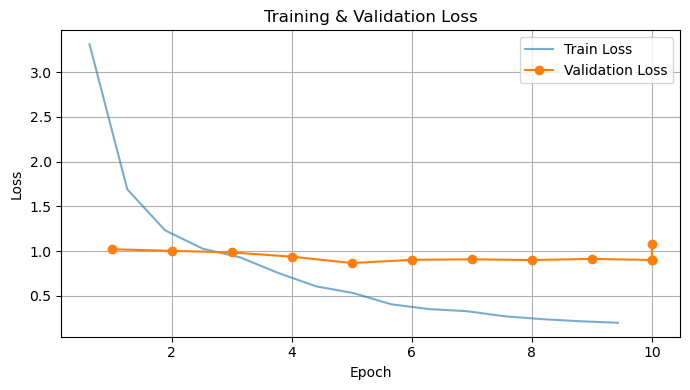

In [13]:
plt.figure(figsize=(7, 4))

plt.plot(df_train["epoch"], df_train["loss"], label="Train Loss", alpha=0.6)
plt.plot(df_eval["epoch"], df_eval["eval_loss"], label="Validation Loss", marker="o")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("loss_curve.png", dpi=300)
plt.show()


## 2. Validation MAE Curve (회귀 모델일 경우만)

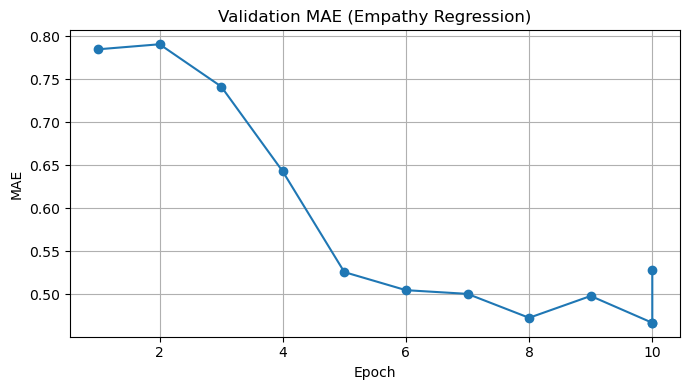

In [14]:
if "eval_mae" in df_eval.columns:
    plt.figure(figsize=(7, 4))

    plt.plot(df_eval["epoch"], df_eval["eval_mae"], marker="o")

    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.title("Validation MAE (Empathy Regression)")
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("val_mae_curve.png", dpi=300)
    plt.show()


## 3. Validation Emotion Accuracy Curve

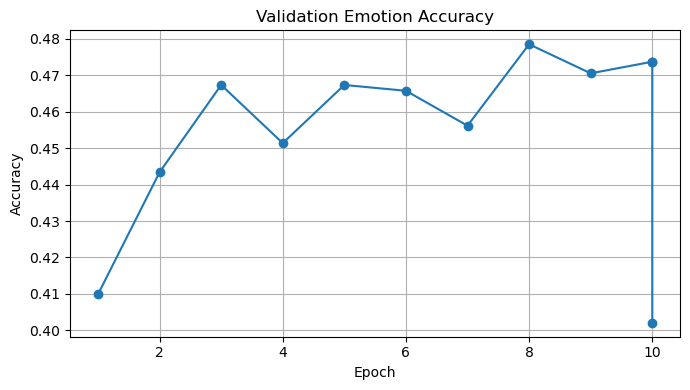

In [15]:
if "eval_emotion_accuracy" in df_eval.columns:
    plt.figure(figsize=(7, 4))

    plt.plot(df_eval["epoch"], df_eval["eval_emotion_accuracy"], marker="o")

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Emotion Accuracy")
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("val_emotion_acc_curve.png", dpi=300)
    plt.show()